## Topic modelling: tests with the  Latent Dirichlet Allocation (LDA) algorithm - Variational Expectation-Maximization (VEM) version.
***

### Installation instructions
*    Download the notebook as "raw" file and save it with extension .ipynb (cut the .txt extension which is added)
*    Create a folder /Data below the folder where you put the notebook and put there the two CSV input files required, from [the corresponding folder in GitHub](https://github.com/eurostat/NLP4Stat/tree/testing/Content%20Database/Enrichment/LDA_2/Data) 
*    Install the necessary libraries from the terminal or RStudio. The required libraries are shown in 1 "Initialization of the R environment". See also the sessionInfo() output at the bottom of the notebook for the versions used. 
*    Launch the notebook    

### 1. Initialization of the R environment.
***
The first step is to load the required libraries.  

In [1]:
options(warn=-1)

#system2('sudo', 'apt-get install libgsl0-dev')
#install.packages("topicmodels_0.2-12.tar.gz",repos=NULL,type="source")

library(tm)
library(ggplot2)
library(topicmodels)
library(tidytext)
library(dplyr)
library(wordcloud2)
library(openxlsx)

Loading required package: NLP


Attaching package: 'ggplot2'


The following object is masked from 'package:NLP':

    annotate



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union





### 2. Data input.
***

We read two of the files extracted from the database, with the glossary articles definitions in _ESTAT_dat_concepts_2021_04_08.csv_ and their titles in _ESTAT_dat_link_info_2021_04_08.csv_. The common key is _id_. **At a later stage, the reading of the files will be directly from the KD**. 

We then drop articles with missing titles and/or definitions and also de-duplicate the records of the resulting file based on these two fields.

In [2]:
dat1 <- read.csv2('Data/ESTAT_dat_concepts_2021_04_08.csv')
dat2 <- read.csv2('Data/ESTAT_dat_link_info_2021_04_08.csv')
dat <- merge(dat1,dat2,by=c('id'),all=FALSE)
dat <- dat[,c('id','title','definition')]

dels <- which(is.na(dat$title))
if(length(dels)>0) dat <- dat[-dels,]

dels <- which(is.na(dat$definition))
if(length(dels)>0) dat <- dat[-dels,]

dels <-which(duplicated(dat$title))
if(length(dels)>0) dat <- dat[-dels,]

dels <- which(duplicated(dat$definition))
if(length(dels)>0) dat <- dat[-dels,]

rm(dat1,dat2)

### 3. Data cleaning.
***

In the next step we do some data cleaning: 

* Replace multiple spaces with single ones in definitions.
* Discard spaces at the start of definitions and titles. 
* Replace space-comma-space by comma-space in definitions.


In [3]:
dat$definition <- gsub(' +',' ',dat$definition) ## discard multiple spaces
dat$definition <- gsub('^ +','',dat$definition) ## discard spaces at start
dat$definition <- gsub(' \\, ','\\, ',dat$definition) ## space-comma-space -> comma-space

dat$title <- gsub('^ +','',dat$title) ## discard spaces at start

### 4. Creating tm objects.
***

Next we create a corpus _texts_ from the articles. This has initially 1285 text entries. We apply the standard pre-processing steps to the texts:

* Remove punctuation and numbers. 
* Convert all to lower case.
* Strip whitespace and apply an English stemmer.

In the end we obtain 331 terms. 

We then create a document-to-term matrix _dmat_, keeping words with minimum length 5, each one in at least 2% of documents and in at most 30% of the documents. We remove documents without terms and convert the matrix to a 1278 x 331 dataframe for inspection. 

Note that in the construction of the document-to-term matrix, we do not request any weights, such as tf-idf. This is a requirement of the LDA algorithm.


In [4]:
texts <- Corpus(VectorSource(dat$definition))
ndocs <- nrow(dat)
cat('ndocs = ',ndocs,'\n')

## apply several pre-processing steps (see package tm)
texts <- tm_map(texts, removePunctuation) 
texts <- tm_map(texts, removeNumbers) 
texts <- tm_map(texts, tolower)

texts <- tm_map(texts, removeWords, stopwords(kind='SMART')) 
texts <- tm_map(texts, stripWhitespace) 
texts <- tm_map(texts, stemDocument, language='english')

## create document-to-term matrix (tf-idf)
## min word length: 5, each term in at least 2% of documents 
## and at most in 30% of documents
dtm <- DocumentTermMatrix(texts,
                          control=list(weighting=weightTf, 
                          wordLengths=c(5, Inf),bounds = 
                          list(global = c(0.02*ndocs,
                                        0.3*ndocs))))

dels <- which(apply(dtm,1,sum)==0) #remove all texts without terms 
if(length(dels)>0) {
  dtm   <- dtm[-dels, ]           
  dat <- dat[-dels,]
}

nTerms(dtm)
#Terms(dtm)

## convert to dataframe for possible export and inspection
dtm.dat <- as.data.frame(as.matrix(dtm))
rownames(dtm.dat)<- dat$title
#print(dtm.dat)

print(inspect(dtm))


ndocs =  1285 


[1] 331

<<DocumentTermMatrix (documents: 1278, terms: 331)>>
Non-/sparse entries: 20782/402236
Sparsity           : 95%
Maximal term length: 12
Weighting          : term frequency (tf)
Sample             :
      Terms
Docs   activ countri econom european member product refer servic state statist
  1267     0       0      2        0      0       0     0      0     1       0
  159      2       0      1        0      0       3     0      0     0       0
  192      6       6      2        8      1       2     0      1     0       6
  195      0       1      0        3      1       0     2      0     1       2
  272      0       1      3        3      8       1     0      0     8       1
  305      0       1      0        1      6       0     8      0     5       2
  306      0       7      0        0      3       0     9      0     3       2
  599     14       0      9        3      0      13     1      3     0       1
  665      0       0      0        1      0      12     0      5     0       4


### 5. Application of the LDA algorithm.
***
We apply the LDA algorithm with k=20 topics. Function _LDA()_ returns an object which contains, among others, a matrix _beta_ expressing, for each topic and term, the probability that the term is generated from the specific topic. For details, see [r package topicmodels](https://cran.r-project.org/web/packages/topicmodels/topicmodels.pdf) and, for a more comprehensive review of the theory, [topicmodels: An R Package for Fitting Topic Models](https://epub.wu.ac.at/3987/1/topicmodels.pdf). 

The specific algorithm used is the default one, the Variational
Expectation-Maximization (VEM) algorithm, see Blei D.M., Ng A.Y., Jordan M.I. (2003). Latent Dirichlet Allocation. _Journal of Machine Learning Research_, 3, 993–1022. The alternative (set with _method="Gibbs"_) is Gibbs sampling. 

Note that could have applied a training-testing approach to find the optimal number of topics, based on fit statistics. However, we preferred to run tests with various values for the number of topics and test the interpretability of the results.   

In the following code, we first group the results by topic and then select the terms with the top _beta_ values in each topic.Then we plot these values and the corresponding terms for each topic.

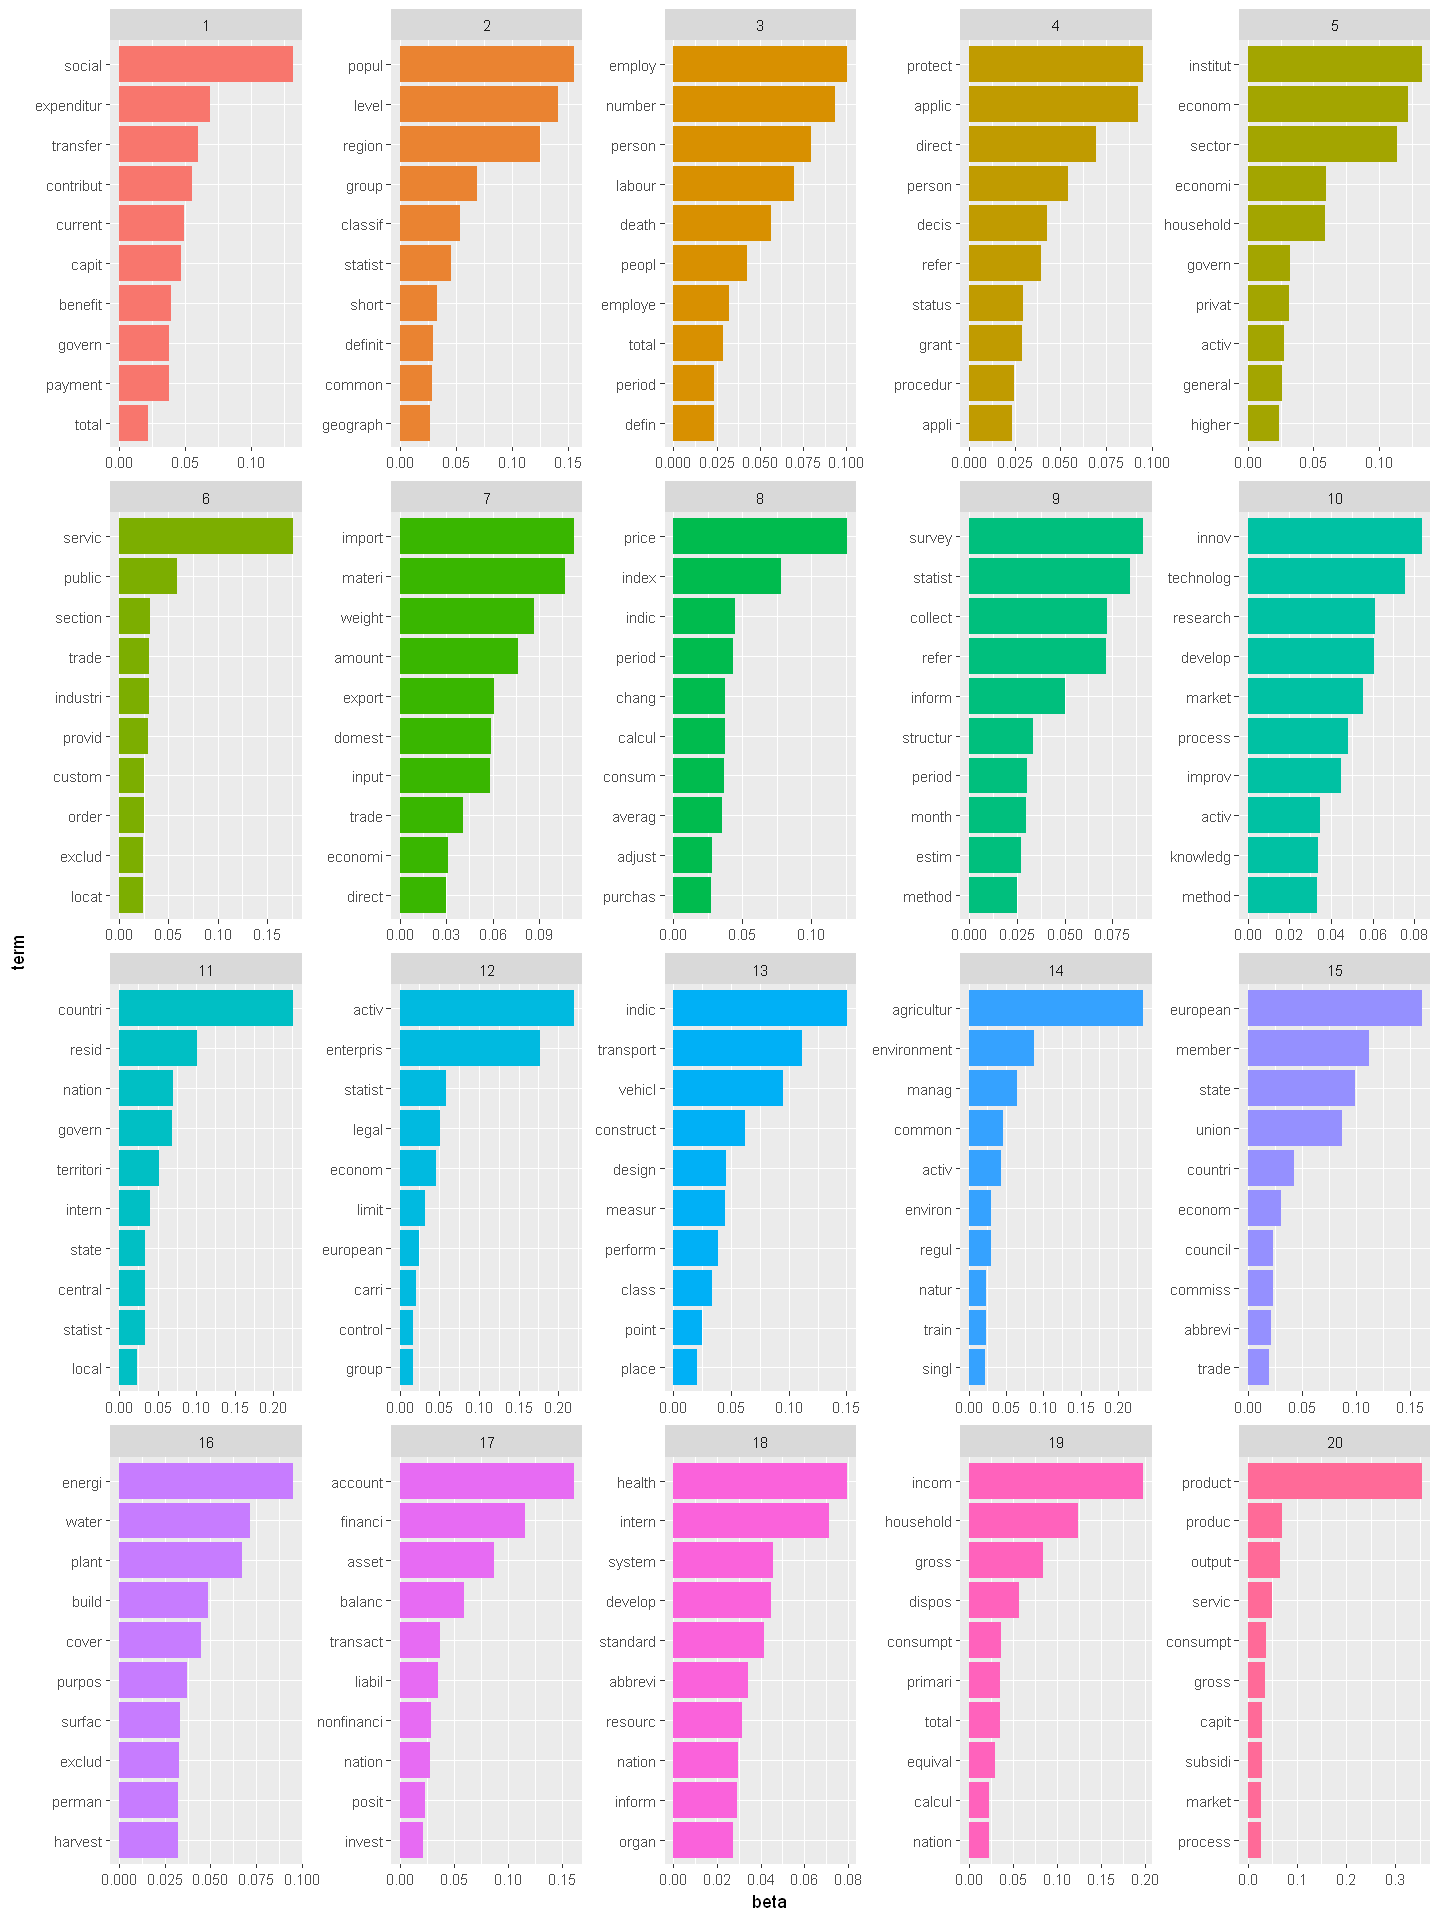

In [5]:
options(repr.plot.width = 12, repr.plot.height = 16)

lda_model <- LDA(dtm, k = 20, control = list(seed = 1234))
topics <- tidy(lda_model, matrix = "beta")

top_terms <- topics %>%
  group_by(topic) %>%
  slice_max(beta, n = 10) %>% 
  ungroup() %>%
  arrange(topic, -beta)

top_terms %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(beta, term, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  scale_y_reordered()

The results with the top 10 terms by topic can be interpreted as follows: 

* Topic 1: Social expenditure and contributions.
* Topic 2: Regions and population. 
* Topic 3: Persons and employment.
* Topic 4: Applications for protection and asylum granting. 
* Topic 5: Economic sectors.
* Topic 6: Public services.
* Topic 7: International trade.
* Topic 8: Price indices. 
* Topic 9: Surveys.
* Topic 10: Technology, R&D and innovation.
* Topic 11: Countries, territories and resident population.
* Topic 12: Business activities and enterprises.
* Topic 13: Transport. 
* Topic 14: Agriculture and the environment.
* Topic 15: The EU and the Member States.
* Topic 16: Energy and water resources.
* Topic 17: Accounts and transactions.
* Topic 18: Healthcare.
* Topic 19: Households disposable income and consumption.
* Topic 20: Production, consumption and gross outputs.



Note that these 10 top most likely terms per topic can be found more easily:

In [6]:
top10termsPerTopic <- terms(lda_model, 10)
top10termsPerTopic

Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
social,popul,employ,protect,institut,servic,import,price,survey,innov,countri,activ,indic,agricultur,european,energi,account,health,incom,product
expenditur,level,number,applic,econom,public,materi,index,statist,technolog,resid,enterpris,transport,environment,member,water,financi,intern,household,produc
transfer,region,person,direct,sector,section,weight,indic,collect,research,nation,statist,vehicl,manag,state,plant,asset,system,gross,output
contribut,group,labour,person,economi,trade,amount,period,refer,develop,govern,legal,construct,common,union,build,balanc,develop,dispos,servic
current,classif,death,decis,household,industri,export,chang,inform,market,territori,econom,design,activ,countri,cover,transact,standard,consumpt,consumpt
capit,statist,peopl,refer,govern,provid,domest,calcul,structur,process,intern,limit,measur,environ,econom,purpos,liabil,abbrevi,primari,gross
benefit,short,employe,status,privat,custom,input,consum,period,improv,state,european,perform,regul,council,surfac,nonfinanci,resourc,total,capit
govern,definit,total,grant,activ,order,trade,averag,month,activ,central,carri,class,natur,commiss,exclud,nation,nation,equival,subsidi
payment,common,period,procedur,general,exclud,economi,adjust,estim,knowledg,statist,control,point,train,abbrevi,perman,posit,inform,calcul,market
total,geograph,defin,appli,higher,locat,direct,purchas,method,method,local,group,place,singl,trade,harvest,invest,organ,nation,process


The actual coefficients shown in these plots are given below. One **suggested output** is a similar matrix, but with the terms which have a _beta_ coefficient above a certain threshold, for example a certain high percentile of all coefficients in the _beta_ matrix.

In [7]:
top_terms

topic,term,beta
<int>,<chr>,<dbl>
1,social,0.13208883
1,expenditur,0.06921355
1,transfer,0.05998507
1,contribut,0.05522134
1,current,0.04938281
1,capit,0.04721410
1,benefit,0.03907777
1,govern,0.03809177
1,payment,0.03758248



The analysis can be extended to take into account the _gamma_ coefficients which express the topic distribution per document. 

A good way to visualize the topics found is by using the posteriori probabilities. These are given in two arrays in the object returned by a call to _posterior()_: _terms_ (# topics x # terms) and _topics_ (# documents x # topics), both with row sums equal to 1


In [8]:
post_results <- posterior(lda_model)
str(post_results)

all(abs(1-rowSums(post_results$terms))<0.000001)
all(abs(1-rowSums(post_results$topics))<0.000001)

List of 2
 $ terms : num [1:20, 1:331] 5.03e-49 7.25e-03 1.91e-30 2.38e-02 8.21e-18 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:20] "1" "2" "3" "4" ...
  .. ..$ : chr [1:331] "appli" "charg" "collect" "context" ...
 $ topics: num [1:1278, 1:20] 0.00506 0.02371 0.00252 0.0057 0.00609 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:1278] "1" "2" "3" "4" ...
  .. ..$ : chr [1:20] "1" "2" "3" "4" ...


[1] TRUE

[1] TRUE

An example is given below for topic 1 which was interpreted as "Social expenditure and contributions". The word cloud verifies this interpretation. **This word cloud is shown only in the interactive notebook and not in the Jupyter notebook download**.

In [9]:
options(repr.plot.width = 8, repr.plot.height = 8)

topicToViz <- 1 # change for your own topic of interest
#select to 40 most probable terms from the topic by sorting the term-topic-probability vector in decreasing order
top40terms <- sort(post_results$terms[topicToViz,], decreasing=TRUE)[1:40]
words <- names(top40terms)

# extract the probabilites of each of the 40 terms
probabilities <- sort(post_results$terms[topicToViz,], decreasing=TRUE)[1:40]
# visualize the terms as wordcloud
wordcloud2(data.frame(words, probabilities), shuffle = FALSE, size = 0.8)

HTML widgets cannot be represented in plain text (need html)

### 6. Documents and topics.
***
In the following, we create a file output with the posterior probabilities of topics contributing to articles. We set a threshold of 0.3 for these probabilities to be shown.

In [10]:
##most likely topics for each document.
topic_titles <- c('Social expenditure and contributions',
'Regions and population', 
'Persons and employment',
'Applications for protection and asylum granting', 
'Economic sectors',
'Public services',
'International trade',
'Price indices', 
'Surveys',
'Technology, R&D and innovation',
'Countries, territories and resident population',
'Business activities and enterprises',
'Transport', 
'Agriculture and the environment',
'The EU and the Member States',
'Energy and water resources',
'Accounts and transactions',
'Healthcare',
'Households disposable income and consumption',
'Production, consumption and gross outputs')


contribs <- topics(lda_model, threshold=0.3)

docs_topics <- as.data.frame(cbind(dat[,c('id','title')]))
for(j in 1:20)
    docs_topics[,paste0('T',j,'_',topic_titles[j])] <- NA

for(row in 1:nrow(docs_topics)){
    vec <- contribs[[row]]
    if(length(vec) > 0)
        for(j in 1:length(vec)){
            docs_topics[row,2+vec[j]] <- post_results$topics[row,vec[j]]
        }
}

docs_topics


,id,title,T1_Social expenditure and contributions,T2_Regions and population,T3_Persons and employment,T4_Applications for protection and asylum granting,T5_Economic sectors,T6_Public services,T7_International trade,T8_Price indices,...,"T11_Countries, territories and resident population",T12_Business activities and enterprises,T13_Transport,T14_Agriculture and the environment,T15_The EU and the Member States,T16_Energy and water resources,T17_Accounts and transactions,T18_Healthcare,T19_Households disposable income and consumption,"T20_Production, consumption and gross outputs"
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,Arrival of tourist at a tourist accommodation establishment,NA,NA,NA,NA,NA,0.4192715,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,3,Nights spent,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,4,Supply side tourism statistics,NA,NA,NA,NA,NA,NA,NA,NA,...,0.4650099,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,5,Tourist,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,0.5915278,NA,NA,NA,NA,NA,NA,NA,NA
5,7,Asia-Europe Meeting (ASEM),NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,0.7389734,NA,NA,NA,NA,NA
6,9,Association of South East Asian Nations (ASEAN),NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,0.4935659,NA,NA,NA,NA,NA
7,10,European Free Trade Association (EFTA),NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,0.8668096,NA,NA,NA,NA,NA
8,11,European Union (EU),NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,0.9360924,NA,NA,NA,NA,NA
9,12,Northeast and South Asia (NESA),NA,0.4158417,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [11]:
write.xlsx(docs_topics,'docs_topics.xlsx')

In [12]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19042)

Matrix products: default

locale:
[1] LC_COLLATE=Greek_Greece.1253  LC_CTYPE=Greek_Greece.1253   
[3] LC_MONETARY=Greek_Greece.1253 LC_NUMERIC=C                 
[5] LC_TIME=Greek_Greece.1253    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] openxlsx_4.1.5     wordcloud2_0.2.1   dplyr_1.0.2        tidytext_0.3.0    
[5] topicmodels_0.2-12 ggplot2_3.3.5      tm_0.7-8           NLP_0.2-1         

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-5      modeltools_0.2-23 tidyselect_1.1.0  slam_0.1-48      
 [5] repr_1.1.3        purrr_0.3.4       reshape2_1.4.4    lattice_0.20-41  
 [9] colorspace_1.4-1  vctrs_0.3.8       generics_0.0.2    htmltools_0.5.0  
[13] SnowballC_0.7.0   stats4_4.0.2      yaml_2.2.1        base64enc_0.1-3  
[17] utf8_1.1.4        rlang_0.4.10      pillar_1.6